# Unsupervised Anomaly Detection
In the unsupervised setting, the class labels of the training set are not available. In the
current problem, the true labels were ignored during training in order to reflect a real-world scenario. Hence, the unsupervised classification models were used to predict the true labels for each record. We've trained the following unsupervised models:

- Isolation Forest

- Cluster-Based Local Outlier Factor (CBLOF)

- Principal Component Analysis (PCA) 

- Elliptic Envelope. 

In the real-world unsupervised problems, the business have to validate the predicted results due to absence of ground truth. In the present problem, however, the predicted labels were validated with the true labels, and the results below show that the unsupervised models predicted so many false positives, but with perfect recall.

In [1]:
%matplotlib inline

# Filter warnings
import warnings

warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

plt.rcParams.update({'font.size': 15})

In [2]:
# Import custom classes
%run -i '../src/transfxns.py'
%run -i '../src/unsup_ml.py'

In [3]:
# Instantiate the classes
transfxn = TransformationPipeline()
model = UnsupervisedModels()
scaler = StandardScaler()

# Load data

In [4]:
df = pd.read_csv('../data/kdd99-unsupervised-ad.csv', header = None)
print("Data size:", df.shape) # print data size
df.columns = ['v_{}'.format(i) for i in range(30)] # column names
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/kdd99-unsupervised-ad.csv'

# Categorical variables encoded as integers

In [8]:
# Convert to string
cols = ['v_6', 'v_7', 'v_8', 'v_9']
for i, val in enumerate(cols):
    df[val] = df[val].astype('O')

# Drop the class label

We will assume that the class label was not provided, which is the case in unsupervised anomaly detection problems. Therefore, the class label will be dropped. However, since the class label is given, we will use it to evaluate the accuracy of the unsupervised models, but in reality this is impossible

In [9]:
 # Map to binary and save for later use
y_true = (df.v_29.map({'n':0, 'o':1})).values

In [10]:
# Drop class label
X = df.drop('v_29', axis =1)

# Transformation pipeline

In [22]:
# Transform and scale data
X_scaled, _, feat_nm = transfxn.preprocessing(X, X)

In [23]:
print('Data size after pre-processing:', X_scaled.shape)

Data size after pre-processing: (620098, 33)


# Unsupervised Models

# 1. Isolation Forest

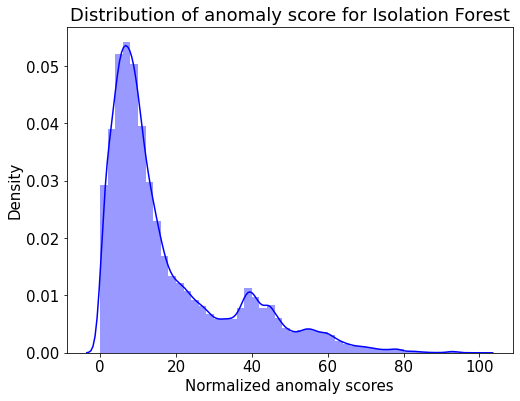

In [71]:
# Train model
if_scores, if_y_pred = model.iforest(X_scaled, n_estimators = 100, random_state= 42)

# Add anomaly score to the data
if_df = df.copy()
if_df['anomaly_score'] = if_scores

# Plot anomaly score distribution
model.plot_dist(if_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Isolation Forest')

## 1.1. Evaluation metric with raw predicted labels

In [72]:
# Evaluation metric with raw predicted labels
model.eval_metric(y_true, if_y_pred, model_nm = 'Isolation Forest')

Test predictions for Isolation Forest
------------------------------------------------------------
Accuracy:  0.830954
AUROC: 0.915333
AUPRC: 0.009936
Predicted classes: [0 1]
Confusion matrix:
 [[514221 104825]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91    619046
           1       0.01      1.00      0.02      1052

    accuracy                           0.83    620098
   macro avg       0.50      0.92      0.46    620098
weighted avg       1.00      0.83      0.91    620098

------------------------------------------------------------


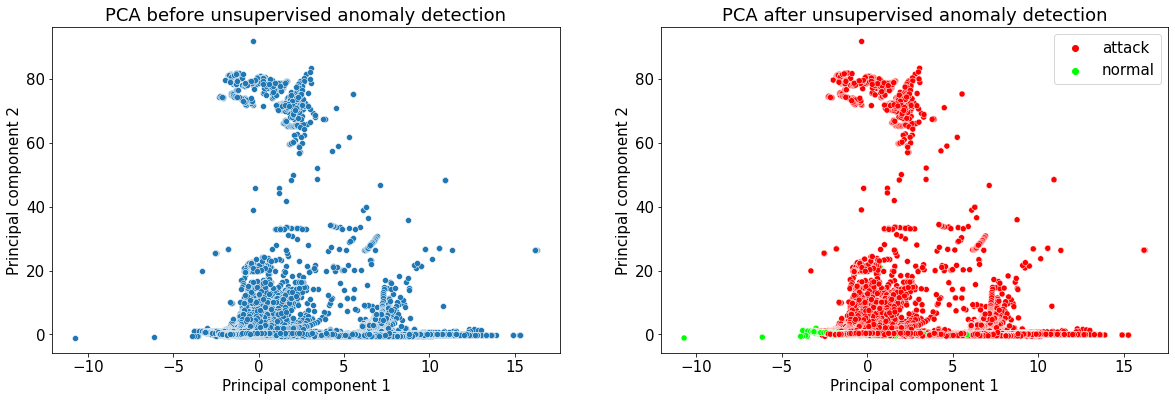

In [73]:
# PCA plot with raw predicted labels
if_y_pred = pd.Series(if_y_pred).map({0:'normal',1: 'attack'})
transfxn.pca_plot(scaler.fit_transform(X), if_y_pred, palette = ['r', 'lime'])

## 1.2. Evaluation metric with tunable threshold
We can reduce the number of false positives by choosing a threshold based on the anomaly score

In [74]:
# Evaluation metric with threshold predicted labels
if_th_pred = np.where(if_scores >= 90, 1, 0)
model.eval_metric(y_true, if_th_pred, model_nm = 'Isolation Forest with threshold >= 90')

Test predictions for Isolation Forest with threshold >= 90
------------------------------------------------------------
Accuracy:  0.999076
AUROC: 0.731457
AUPRC: 0.456357
Predicted classes: [0 1]
Confusion matrix:
 [[619038      8]
 [   565    487]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    619046
           1       0.98      0.46      0.63      1052

    accuracy                           1.00    620098
   macro avg       0.99      0.73      0.81    620098
weighted avg       1.00      1.00      1.00    620098

------------------------------------------------------------


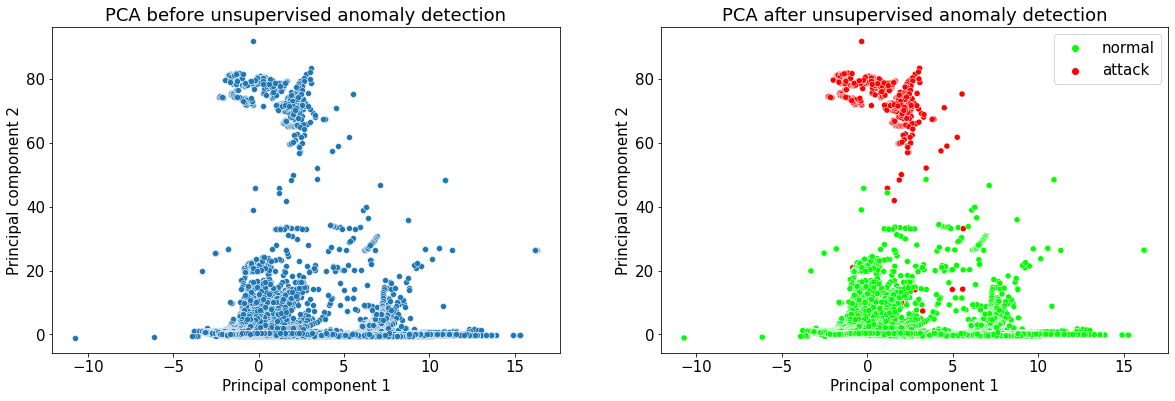

In [75]:
# PCA plot with raw predicted labels
if_th_pred = pd.Series(if_th_pred).map({0:'normal',1: 'attack'})
transfxn.pca_plot(scaler.fit_transform(X), if_th_pred, palette = ['lime', 'r'])

# 2. Cluster-Based Local Outlier Factor

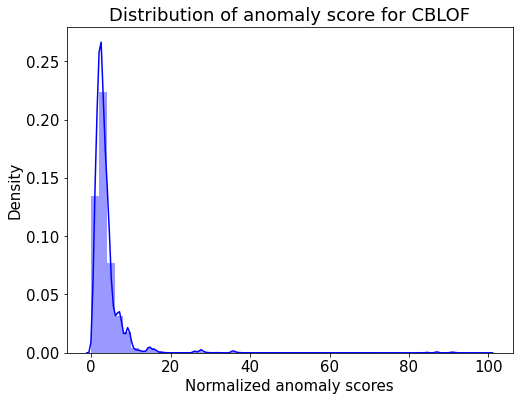

In [16]:
# Train model
cblof_scores, cblof_y_pred = model.cblof(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
cblof_df = df.copy()
cblof_df['anomaly_score'] = cblof_scores

# Plot anomaly score distribution
model.plot_dist(cblof_df.anomaly_score, color = 'b',
                title = 'Distribution of anomaly score for CBLOF')

In [17]:
# Evaluation metric with raw predicted labels
model.eval_metric(y_true, cblof_y_pred, model_nm = 'Cluster-Based Local Outlier Factor')

Test predictions for Cluster-Based Local Outlier Factor
------------------------------------------------------------
Accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------


# 3. PCA

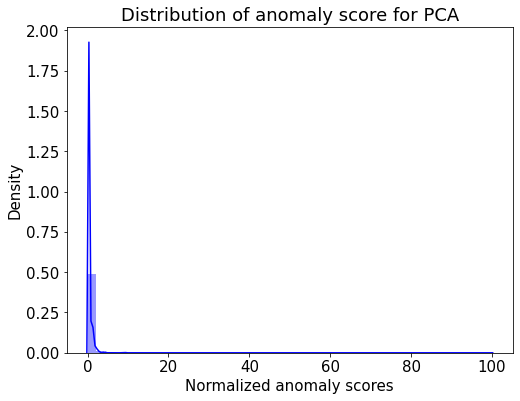

In [18]:
# Train model
pca_scores, pca_y_pred = model.pca(X_scaled, n_components = None, contamination = 0.1)

# Add anomaly score to the data
pca_df = df.copy()
pca_df['anomaly_score'] = pca_scores

# Plot anomaly score distribution
model.plot_dist(pca_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for PCA')

In [19]:
# Evaluation metric with raw predicted labels
model.eval_metric(y_true, pca_y_pred, model_nm = 'Principal Component Analysis')

Test predictions for Principal Component Analysis
------------------------------------------------------------
Accuracy:  0.901696
AUROC: 0.950765
AUPRC: 0.016965
Predicted classes: [0 1]
Confusion matrix:
 [[558088  60958]
 [     0   1052]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      1.00      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.95      0.49    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------


# 4. Elliptic Envelope

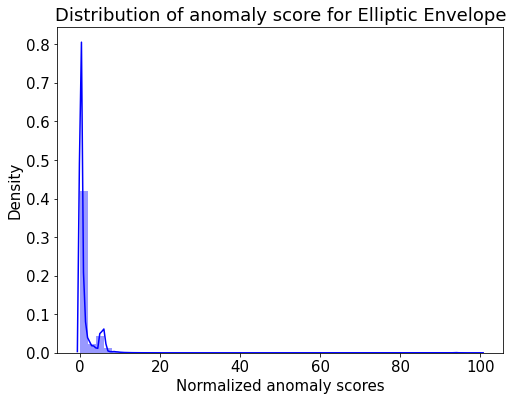

In [20]:
# Train model
ellip_scores, ellip_y_pred = model.cov(X_scaled, contamination = 0.1, random_state = 42)

# Add anomaly score to the data
ellip_df = df.copy()
ellip_df['anomaly_score'] = ellip_scores

# Plot anomaly score distribution
model.plot_dist(ellip_df.anomaly_score, color = 'b', 
                title = 'Distribution of anomaly score for Elliptic Envelope')

In [21]:
# Evaluation metric with raw predicted labels
model.eval_metric(y_true, ellip_y_pred, model_nm = 'Elliptic Envelope')

Test predictions for Elliptic Envelope
------------------------------------------------------------
Accuracy:  0.901312
AUROC: 0.894110
AUPRC: 0.013536
Predicted classes: [0 1]
Confusion matrix:
 [[557969  61077]
 [   119    933]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.90      0.95    619046
           1       0.02      0.89      0.03      1052

    accuracy                           0.90    620098
   macro avg       0.51      0.89      0.49    620098
weighted avg       1.00      0.90      0.95    620098

------------------------------------------------------------
